# The Capture24 dataset

<img src="ax3_orientation.jpg" width="300"/>

The Capture24 dataset consists of wrist-worn accelerometer measurements collected from about 150 participants that wore the device for 24 hours.
Along with the accelerometer, the participants also wore a body camera that recorded their daily activities. Thus, an activity label is assigned to every 30 seconds of accelerometer reading. The identified activities are *sleep*, *sedentary*, *tasks-light*, *walking* and *moderate*.

The two main files we will work with are `X_raw.dat` and `capture24.npz`. The
first contains the raw accelerometer measurements and the latter is a bundle
of numpy arrays including, among other things, hand-crafted features extracted from the raw measurements and corresponding activity labels.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

# A useful plotting function
def my_scatter_plot(X, y):
    fig, ax = plt.subplots()
    for i in range(utils.NUM_CLASSES):
        ax.scatter(X[y==i, 0], X[y==i, 1],
            c=utils.COLORS[i], label=utils.CLASSES[i], alpha=0.25, s=10)
    fig.legend()
    return fig, ax

###### Load the dataset files 

In [2]:
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
X_feats, y, pid, time, annotation = \
    data['X_feats'], data['y'], data['pid'], data['time'], data['annotation']
print('X_feats shape:', X_feats.shape)
print('y shape:', y.shape)
print('pid shape:', pid.shape)
print('time shape:', time.shape)
print('annotation shape:', annotation.shape)
# X_raw = utils.load_raw('X_raw.dat')
X_raw = np.load('X_raw_small.npy')
print('X_raw shape:', X_raw.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
X_feats shape: (11016, 125)
y shape: (11016,)
pid shape: (11016,)
time shape: (11016,)
annotation shape: (11016,)
X_raw shape: (11016, 3, 3000)


###### Description of the arrays

- `X_raw` array of shape `(N,3,3000)` where each row corresponds to 30 seconds of raw tri-axial measurement at 100Hz.

- `X_feats` numpy array of shape `(N,125)` where each row corresponds to *hand-crafted features* extracted from the raw 30 seconds measurement. These include mean acceleration, covariances between axes, Fourier coefficients, estimated pitch, yaw and roll, etc.

- `y` numpy array of shape `(N,)` indicating the activity (0: sleep, 1: sedentary, 2: tasks-light, 3: walking, 4: moderate) performed during the 30 seconds instance.

- `time` numpy array of shape `(N,)` indicating the start time of the corresponding measurement.

- `pid` numpy array of shape `(N,)` indicating the participant ID for the corresponding instance.

- `annotation` numpy array of shape `(N,)` containing fine-grained descriptions of the activity performed in the corresponding instance.

Arrays `X_feats`, `y`, `time`, `pid` and `annotation` are stored in a single `capture24.npz` file, while `X_raw` is stored separately as a numpy `memmap` due to its large size (~11GB).

**Note:**
The provided arrays `X_feats`, `X_raw`, `y`, etc. are so that consecutive
rows correspond to continuous measurements in time for a same participant.
Discontinuities will naturally occur at the edges between two participants, which can be inferred from the `pid` array.
Interrupts in the measurement within a same participant may also occur
(e.g. device run out of battery), and can be inferred from `time` array.

# Visualization
Visualizing the dataset is an important part of data science. This can
provide useful insights about the problem at hand.

Let's visualize one instance of each activity identified:

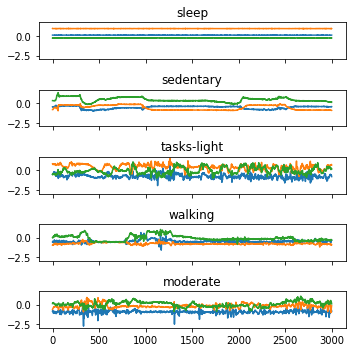

In [3]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(5,5))
for i in range(utils.NUM_CLASSES):
    axs[i].plot(X_raw[y == i][0].T)
    axs[i].set_title(utils.CLASSES[i])
fig.tight_layout()
fig.show()

After visualizing individual instances, the next step is to visualize
our dataset as a whole to have a grasp of the data distribution. A
standard visualization approach is to scatter-plot the two principal
components of our dataset.
For performance, let us perform the visualization on
a smaller subset of our data since our data is rather big:

In [4]:
# grab data from five participants
mask = np.isin(data['pid'], [1, 2, 3, 4, 5])
X_raw = X_raw[mask]
X_feats = X_feats[mask]
y = y[mask]
pid = pid[mask]
time = time[mask]
annotation = annotation[mask]

###### PCA visualization 

Plotting first two PCA components...


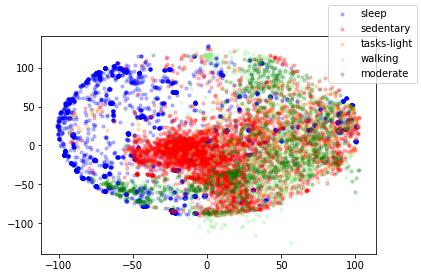

In [5]:
print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_raw_scaled = scaler.fit_transform(X_raw.reshape(X_raw.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_raw_scaled)
fig, ax = my_scatter_plot(X_pca, y)
fig.show()

###### t-SNE visualization
The PCA plot is already very informative. What if we want to
visualize more components? A popular high-dimensional data visualization tool
is _t-distributed stochastic neighbor embedding_ (t-SNE). We next use t-SNE to
visualize 128 principal components of our raw dataset:

Plotting t-SNE on PCA components...


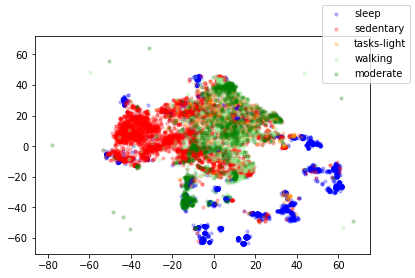

In [6]:
print("Plotting t-SNE on PCA components...")
pca = decomposition.PCA(n_components=128)  # 128 components
X_pca = pca.fit_transform(X_raw_scaled)
tsne = manifold.TSNE(n_components=2,  # project down to 2 components
    init='random', random_state=42, perplexity=100)
X_tsne_pca = tsne.fit_transform(X_pca)
fig, ax = my_scatter_plot(X_tsne_pca, y)
fig.show()

###### t-SNE on `X_feats`

Finally, let's perform a t-SNE visualization this time on the
hand-crafted features `X_feats`:

Plotting t-SNE on hand-crafted features...


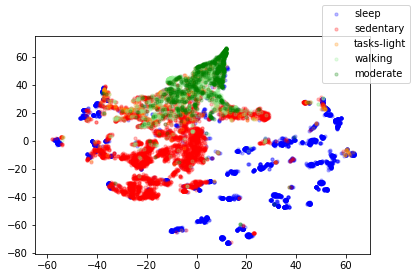

In [7]:
print("Plotting t-SNE on hand-crafted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=100)
X_tsne_feats = tsne.fit_transform(X_feats)
fig, ax = my_scatter_plot(X_tsne_feats, y)
fig.show()

Our preliminary plots seem to suggest that classifying "sleep" and
"sedentary" activities may be easy while classifying "tasks-light", "walking"
and "moderate" activities may be more challenging.

###### Ideas

- Tune the `perplexity` parameter of t-SNE to see how it affects the plots.
- Our dataset is highly unbalanced:

In [8]:
print(np.unique(y, return_counts=True))

(array([0, 1, 2, 3, 4]), array([4160, 4644,  372,  887,  953]))


As seen, there is barely any "tasks-light" activities (category 2). To aid the
visualization, try balancing the activities to be scatter-plotted.